In [1]:
import numpy as np
import csv
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import least_squares
from scipy.integrate import odeint
import pandas as pd
import re

Let's find the beginning date and do some preprocessing here.

In [2]:
df = pd.read_csv('project10_data.csv')

# Initialize the max

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")

# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


In [3]:
# Get population
population = df["Population"][0]
accumulated_cases = np.array(df_clean.iloc[0])
accumulated_deaths = np.array(df_clean.iloc[1])

T_max = 119
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 - 7]

# When accumulated_deaths > 5, the simulation starts
t_deaths_0 = np.argwhere(accumulated_deaths > 5)[1, 0]


# Exercise 1

The first step is to generate a set of potential simulation params. In this case, we sampled 10 for each of the 3 parameters. We then generated a set of 1000 simulations using these parameters. 

In [4]:
# Exercise 1

omegas = []
for alpha in np.linspace(0.05, 0.2, 10):
    for r0 in np.linspace(1.5, 1.9, 10):
        beta = alpha * r0
        for p in np.linspace(0.02, 0.1, 10):
            omegas.append((alpha, beta, r0, p * population))

print(f"Number of simulations: {len(omegas)}")

Number of simulations: 1000


Then, let's implement the SIR model following our PPT. We also need to implement an ode solver. We will use the Euler method here.

In [5]:
def f(y, t, alpha, beta, N):
    S, I, R = y
    d0 = -beta * S * I/N  # derivative of S(t)
    d1 = beta * S * I/N - alpha * I  # derivative of I(t)
    d2 = alpha * I  # derivative of R(t)
    return [d0, d1, d2]


def SIR_simulation(alpha, beta, N):
    y_0 = [N, I[0], 0]  # Susceptible, Infected, Recovered

    t = np.arange(start=1, stop=T_max+1.01, step=0.01)
    y = odeint(partial(f, alpha=alpha, beta=beta, N=N), y_0, t)
    y = y[::100]

    return y[:, 0], y[:, 1], y[:, 2]

Then, we need to run simulations for all ps (Sub question 1 to 3)

[p=1] alpha: 0.06666666666666668, beta: 0.10000000000000002, r0: 1.5, N: 17630.98, gamma: 0.018498711967563457, J: 9074656.79481604


<Figure size 640x480 with 0 Axes>

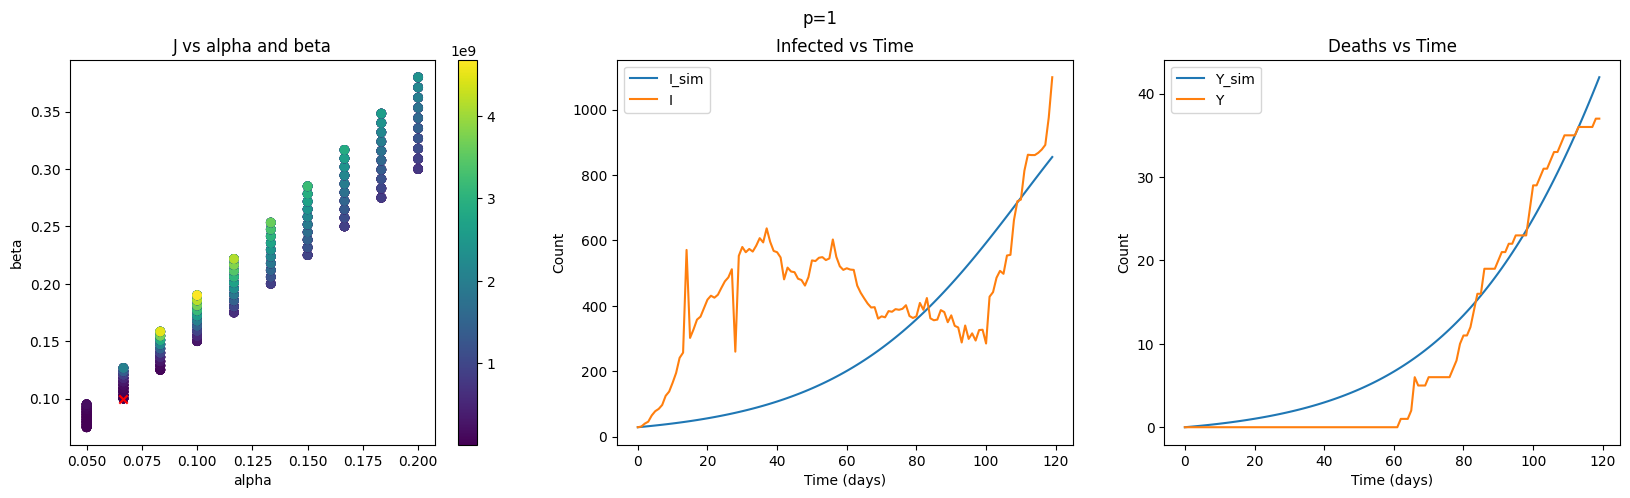

[p=2] alpha: 0.06666666666666668, beta: 0.10000000000000002, r0: 1.5, N: 17630.98, gamma: 0.017956386997850907, J: 9074629.4907743


<Figure size 640x480 with 0 Axes>

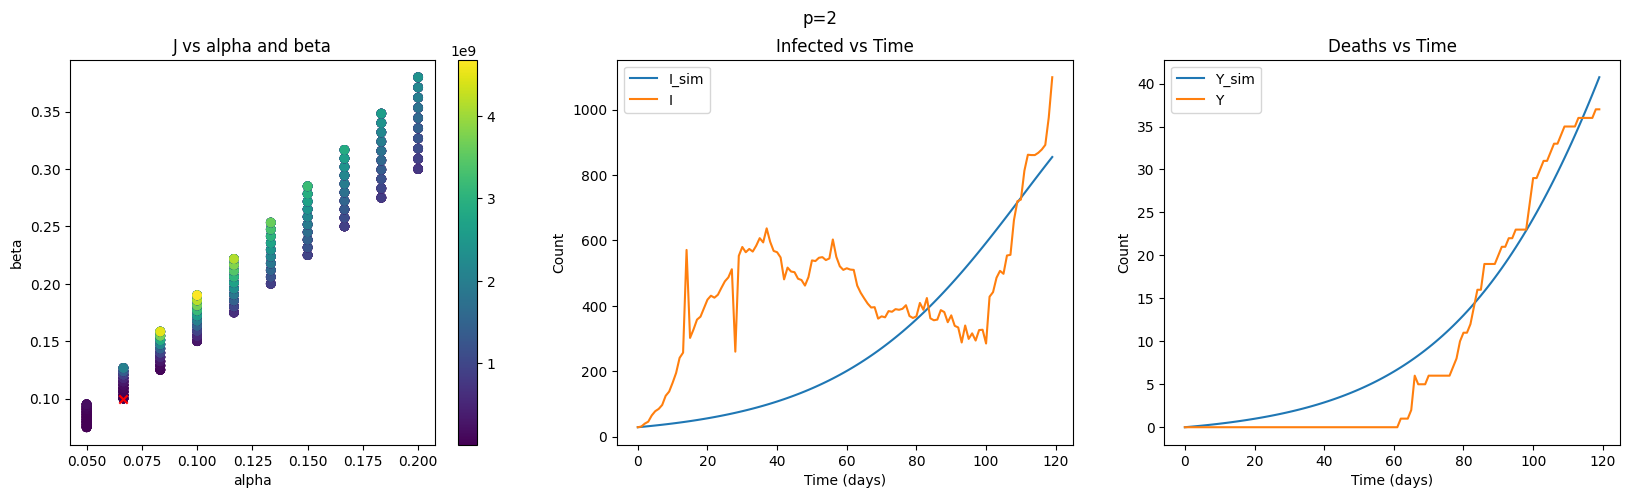

[p=inf] alpha: 0.06666666666666668, beta: 0.10296296296296299, r0: 1.5444444444444445, N: 17630.98, gamma: 0.014157583975375348, J: 534.0142244306119


<Figure size 640x480 with 0 Axes>

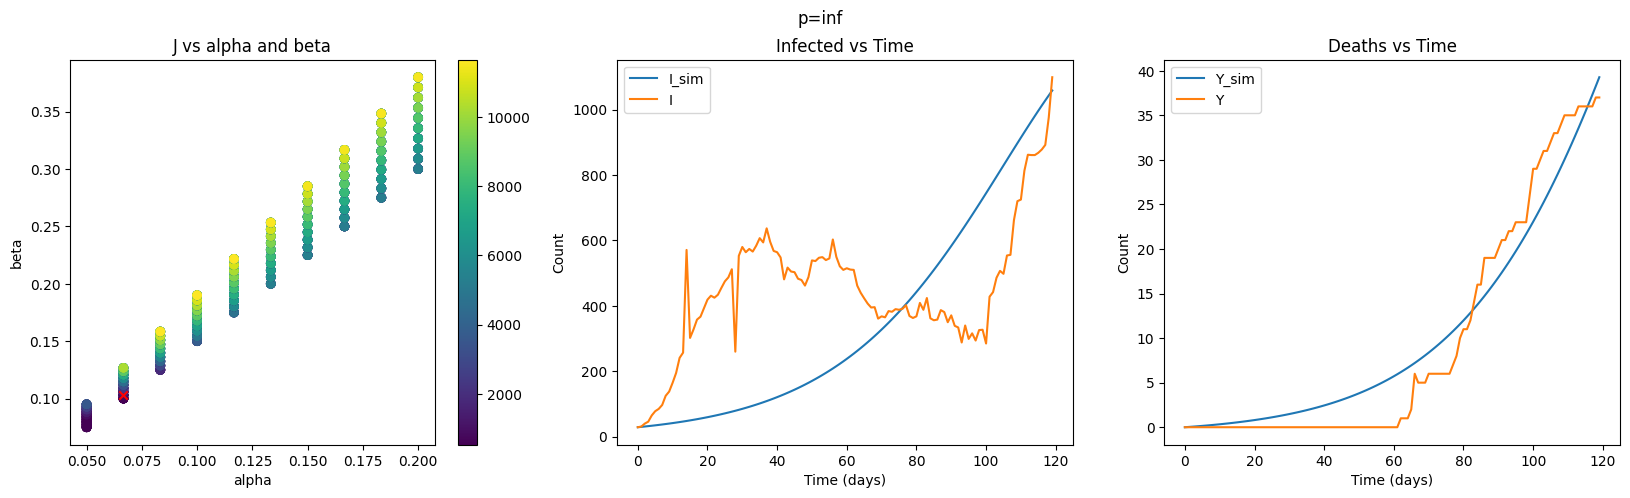

In [6]:
ps = [1, 2, np.inf]

for p in ps:
    lambda_ = 1
    minimum = None
    all_results = []

    for alpha, beta, r0, N in omegas:
        S_sim, I_sim, R_sim = SIR_simulation(alpha, beta, N)
        gamma = least_squares(lambda x: np.linalg.norm(accumulated_deaths[:T_max+1] - x * R_sim, ord=p), 1, bounds=(0, 1))
        gamma = gamma.x[0]

        if p != np.inf:
            J = np.sum((I - I_sim) ** 2) + lambda_ * np.sum((accumulated_deaths[:T_max+1] - gamma * R_sim) ** 2)
        else:
            J = np.max(np.abs(I - I_sim)) + lambda_ * np.max(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim))
            
        if minimum is None or J < minimum[0]:
            minimum = (J, alpha, beta, r0, N, gamma)
        
        all_results.append((J, alpha, beta, r0, N, gamma))

    J, alpha, beta, r0, N, gamma = minimum
    all_results = np.array(all_results)

    print(f"[p={p}] alpha: {alpha}, beta: {beta}, r0: {r0}, N: {N}, gamma: {gamma}, J: {J}")

    # Sub Question (2)
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"p={p}")

    temp = ax1.scatter(all_results[:, 1], all_results[:, 2], c=all_results[:, 0])
    ax1.scatter(alpha, beta, c="red", marker="x")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("beta")
    ax1.set_title("J vs alpha and beta")
    fig.colorbar(temp, ax=ax1)
    # ax1.clim(np.min(all_results[:, 0]), np.max(all_results[:, 0]))

    # Sub Question (3)
    S_sim, I_sim, R_sim = SIR_simulation(alpha, beta, N)

    ax2.plot(I_sim, label="I_sim")
    ax2.plot(I, label="I")
    ax2.legend()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Count")
    ax2.set_title("Infected vs Time")

    ax3.plot(gamma * R_sim, label="Y_sim")
    ax3.plot(accumulated_deaths[:T_max+1], label="Y")
    ax3.legend()
    ax3.set_xlabel("Time (days)")
    ax3.set_ylabel("Count")
    ax3.set_title("Deaths vs Time")

    plt.show()
    

## Sub question (4)

The above data shows that the expected $\alpha$ is between 0.05 and 0.075, while the expected $\beta$ is between 0.09 to 0.11 (R0 = 1.5).  
Since the above graphs look good, we probably rerun the experiments with $\alpha \in [0.05, 0.075]$ and $R0 \in [1.4, 1.6]$.

# Exercise 2

The first step is to generate a set of potential simulation params. In this case, we sampled 7 for each of the 4 parameters. We then generated a set of 2401 simulations using these parameters. 

In [7]:
## Similar to 1

omegas = []
for alpha in np.linspace(0.05, 0.4, 7):
    for delta in np.linspace(0.05, 0.4, 7):
        for r0 in np.linspace(1.5, 1.9, 7):
            beta = alpha * r0
            for p in np.linspace(0.02, 0.1, 7):
                omegas.append((alpha, beta, delta, r0, p * population))

print(f"Number of simulations: {len(omegas)}")

Number of simulations: 2401


Then, let's implement the SEIR model following our PPT. We also need to implement an ode solver. We will use the Euler method here.

In [8]:
def f(y, t, alpha, beta, delta, N):
    S, E, I, R = y
    d0 = -beta * S * I/N  # derivative of S(t)
    d1 = beta * S * I/N - delta * E  # derivative of E(t)
    d2 = delta * E - alpha * I  # derivative of I(t)
    d3 = alpha * I  # derivative of R(t)
    return [d0, d1, d2, d3]


def SEIR_simulation(alpha, beta, delta, N):
    y_0 = [N, I[0], I[0], 0]  # Susceptible, Infected, Recovered

    t = np.arange(start=1, stop=T_max+1.01, step=0.01)
    y = odeint(partial(f, alpha=alpha, beta=beta, delta=delta, N=N), y_0, t)
    y = y[::100]

    return y[:, 0], y[:, 1], y[:, 2], y[:, 3]

Then, we need to run simulations for all ps (Sub question 1 to 3)

[p=1] alpha: 0.05, beta: 0.08166666666666667, delta: 0.4, r0: 1.6333333333333333, N: 17630.98, gamma: 0.02279269961275562, J: 7926882.01105739


<Figure size 640x480 with 0 Axes>

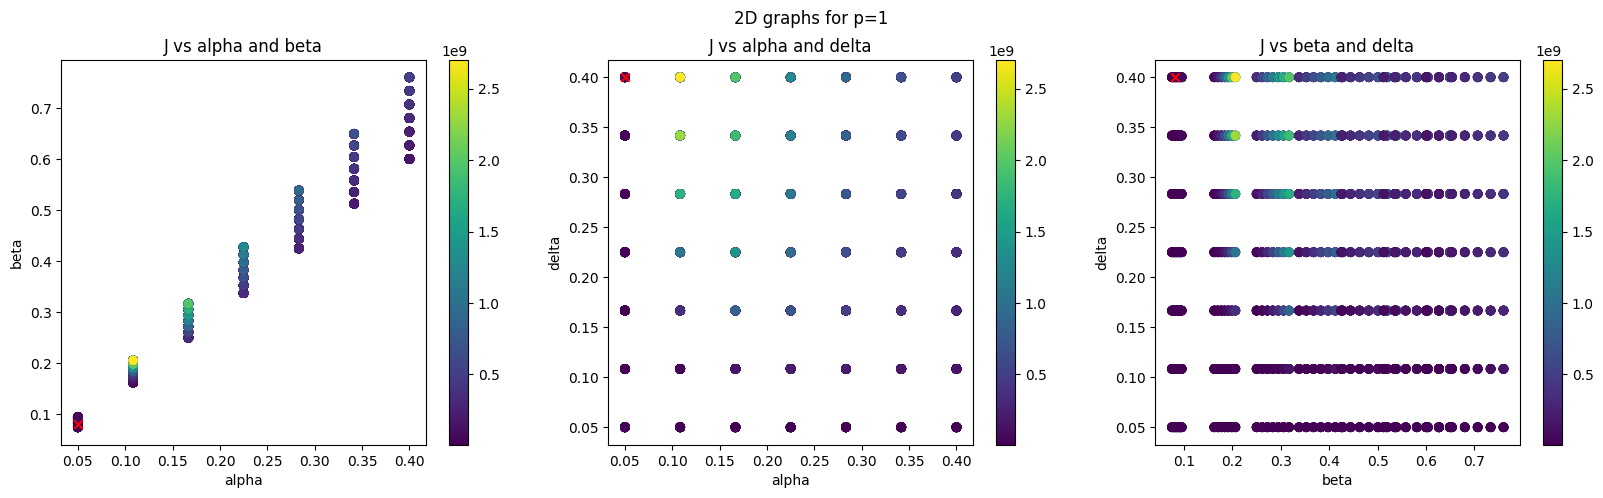

<Figure size 640x480 with 0 Axes>

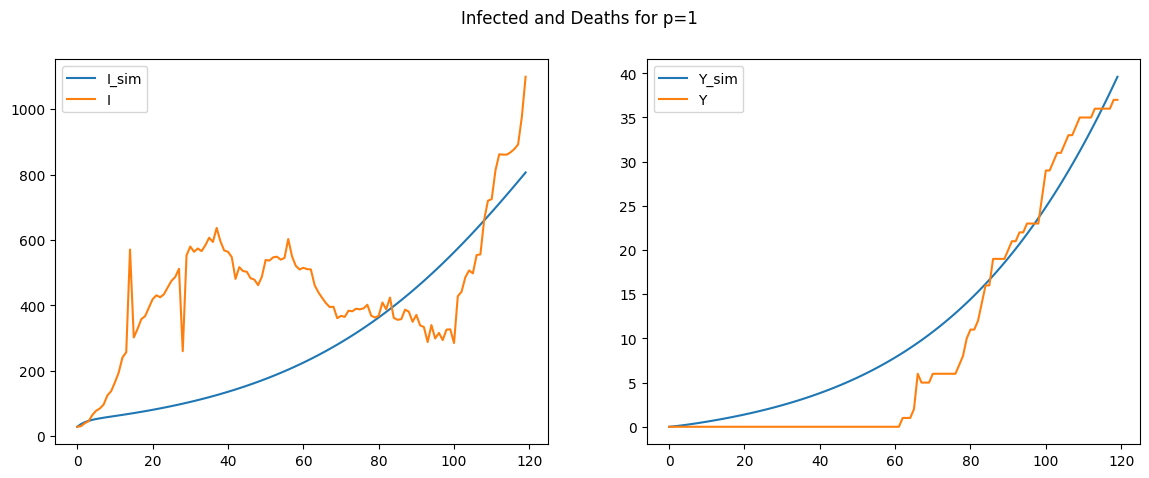

[p=2] alpha: 0.05, beta: 0.08166666666666667, delta: 0.4, r0: 1.6333333333333333, N: 17630.98, gamma: 0.022118701408632174, J: 7926854.746136232


<Figure size 640x480 with 0 Axes>

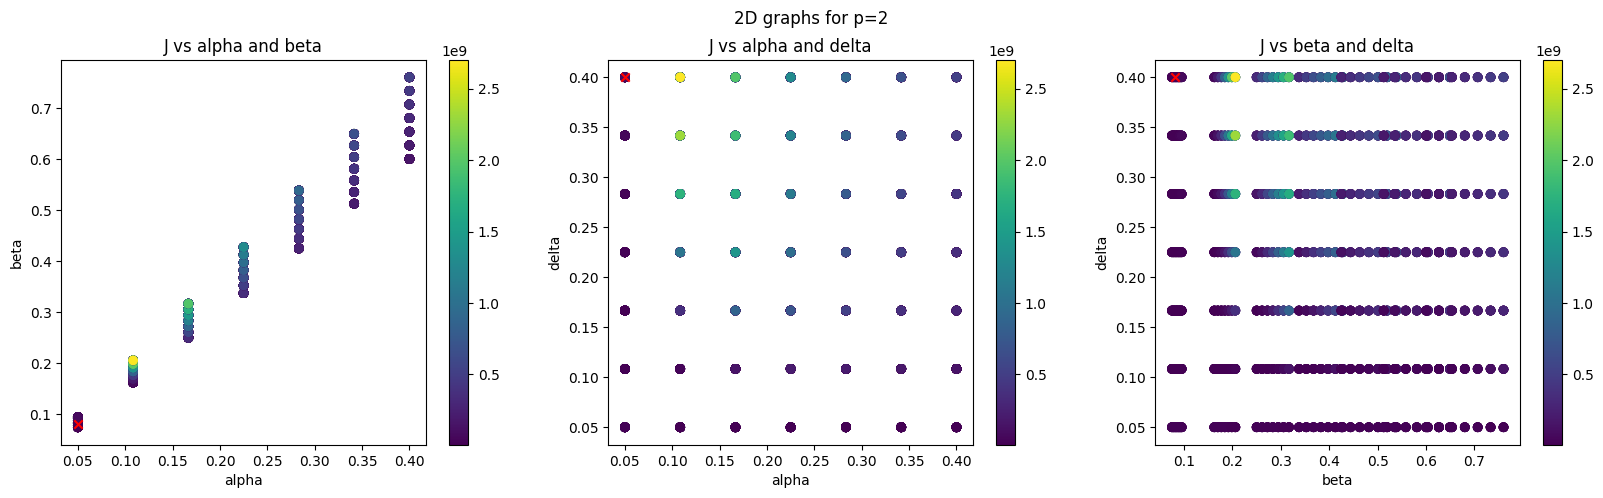

<Figure size 640x480 with 0 Axes>

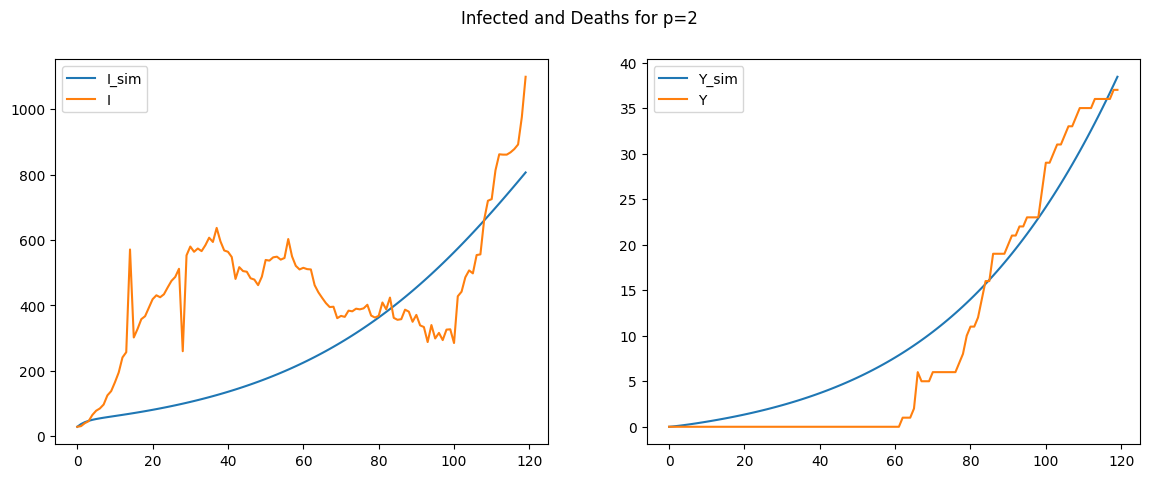

[p=inf] alpha: 0.05, beta: 0.085, delta: 0.4, r0: 1.7, N: 29384.966666666667, gamma: 0.016802744627468807, J: 506.48109392231873


<Figure size 640x480 with 0 Axes>

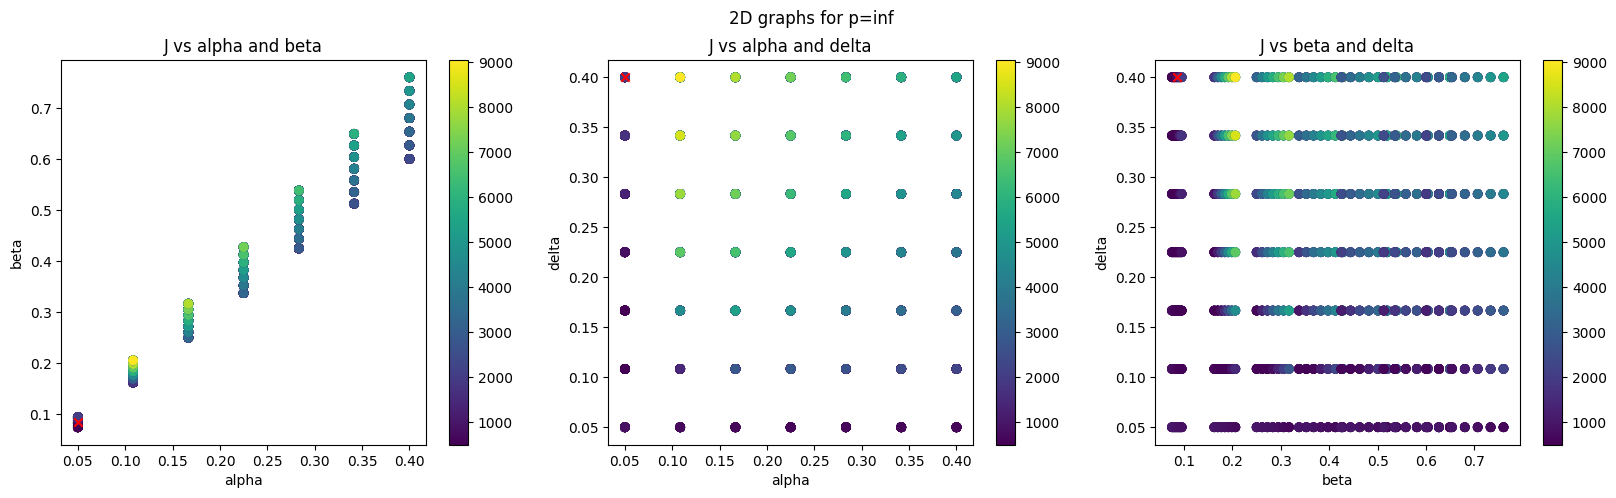

<Figure size 640x480 with 0 Axes>

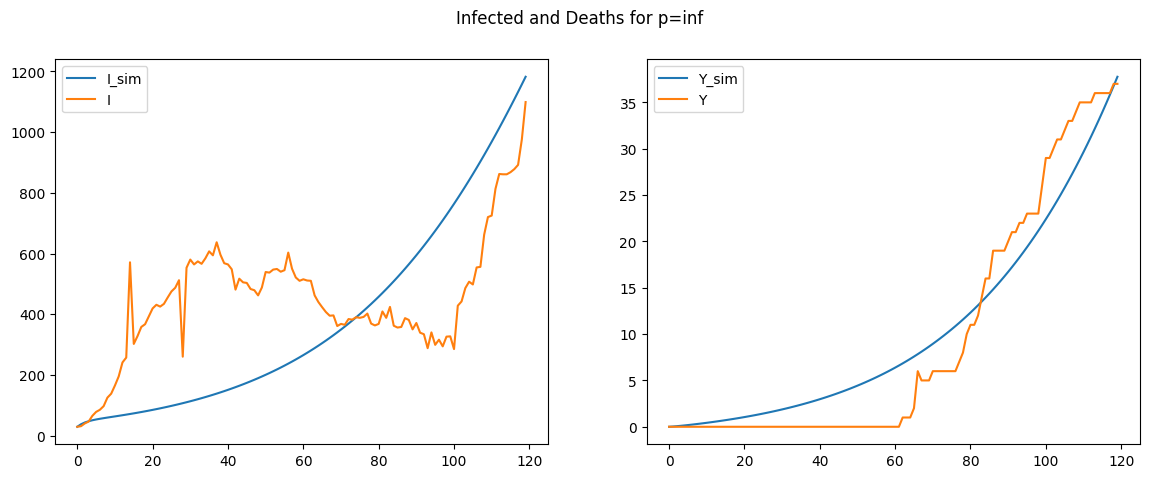

In [9]:
ps = [1, 2, np.inf]

for p in ps:
    lambda_ = 1
    minimum = None
    all_results = []

    for alpha, beta, delta, r0, N in omegas:
        S_sim, E_sim, I_sim, R_sim = SEIR_simulation(alpha, beta, delta, N)
        gamma = least_squares(lambda x: np.linalg.norm(accumulated_deaths[:T_max+1] - x * R_sim, ord=p), 1, bounds=(0, 1))
        gamma = gamma.x[0]

        if p != np.inf:
            J = np.sum((I - I_sim) ** 2) + lambda_ * np.sum((accumulated_deaths[:T_max+1] - gamma * R_sim) ** 2)
        else:
            J = np.max(np.abs(I - I_sim)) + lambda_ * np.max(np.abs(accumulated_deaths[:T_max+1] - gamma * R_sim))
            
        if minimum is None or J < minimum[0]:
            minimum = (J, alpha, beta, delta, r0, N, gamma)
        
        all_results.append((J, alpha, beta, delta, r0, N, gamma))

    J, alpha, beta, delta, r0, N, gamma = minimum
    all_results = np.array(all_results)

    print(f"[p={p}] alpha: {alpha}, beta: {beta}, delta: {delta}, r0: {r0}, N: {N}, gamma: {gamma}, J: {J}")

    # Sub Question (2)
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"2D graphs for p={p}")

    temp = ax1.scatter(all_results[:, 1], all_results[:, 2], c=all_results[:, 0])
    ax1.scatter(alpha, beta, c="red", marker="x")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("beta")
    ax1.set_title("J vs alpha and beta")
    fig.colorbar(temp, ax=ax1)

    temp = ax2.scatter(all_results[:, 1], all_results[:, 3], c=all_results[:, 0])
    ax2.scatter(alpha, delta, c="red", marker="x")
    ax2.set_xlabel("alpha")
    ax2.set_ylabel("delta")
    ax2.set_title("J vs alpha and delta")
    fig.colorbar(temp, ax=ax2)
    
    temp = ax3.scatter(all_results[:, 2], all_results[:, 3], c=all_results[:, 0])
    ax3.scatter(beta, delta, c="red", marker="x")
    ax3.set_xlabel("beta")
    ax3.set_ylabel("delta")
    ax3.set_title("J vs beta and delta")
    fig.colorbar(temp, ax=ax3)

    plt.show()

    # Sub Question (3)
    S_sim, E_sim, I_sim, R_sim = SEIR_simulation(alpha, beta, delta, N)

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(f"Infected and Deaths for p={p}")

    ax1.plot(I_sim, label="I_sim")
    ax1.plot(I, label="I")
    ax1.legend()

    ax2.plot(gamma * R_sim, label="Y_sim")
    ax2.plot(accumulated_deaths[:T_max+1], label="Y")
    ax2.legend()
    plt.show()
    

## Sub question (4)

The above data shows that the expected $\alpha$ is 0.05 (on the very left), while the expected $\beta$ is between 0.05 to 0.1 (R0 = 1.5).  
The $\delta$ is on the very top, so we probably need to improve the sampling range.  
We probably rerun the experiments with $\alpha \in [0.04, 0.075]$, $R0 \in [1.4, 1.6]$, and $\delta \in [0.35, 0.5]$.